In [1]:
import os

# os.environ["PYSYN_CDBS"] = "/home/ruizhew/POSEIDON/inputs/stellar_grids/"
# os.environ["POSEIDON_input_data"] = "/home/ruizhew/POSEIDON/inputs/"

In [2]:
from __future__ import absolute_import, unicode_literals, print_function
from POSEIDON.high_res import (
    fast_filter,
    loglikelihood_sysrem,
    get_rot_kernel,
    fit_uncertainties,
    fit_uncertainties_and_remove_outliers,
)
import math, os
import numpy as np
import pickle
import pickle
from scipy import constants
from numba import jit
from astropy.io import fits
from scipy import interpolate
from POSEIDON.core import (
    create_star,
    create_planet,
    define_model,
    make_atmosphere,
    read_opacities,
    wl_grid_constant_R,
    wl_grid_line_by_line,
    compute_spectrum,
)
from POSEIDON.constants import R_Sun
from POSEIDON.visuals import plot_stellar_flux
from POSEIDON.constants import R_J, M_J
import numpy as np
from spectres import spectres
from tqdm import tqdm
from multiprocessing import Pool
import h5py
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter1d, median_filter

/home/rwang/miniconda3/envs/poseidon/lib/python3.9/site-packages/POSEIDON/high_res.py:20: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  def get_rot_kernel(V_sin_i, wl, W_conv):
/home/rwang/miniconda3/envs/poseidon/lib/python3.9/site-packages/POSEIDON/absorption.py:1466: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  def store_Rayleigh_eta_LBL(wl_model, chemical_s

In [3]:
from scipy.optimize import minimize
from sklearn.decomposition import TruncatedSVD

In [4]:
data = h5py.File("./data/WASP-121b-self-aligned.h5", "a")

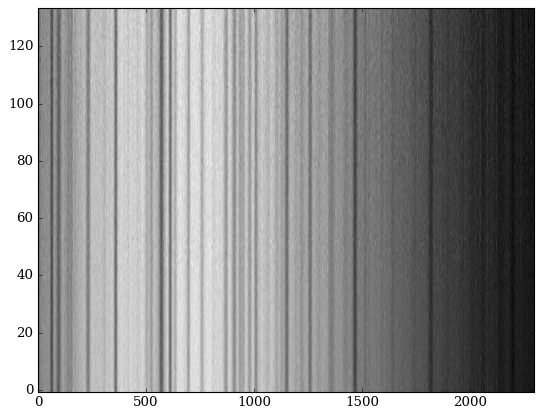

In [5]:
plt.imshow(
    data["blue/flux_blaze_corrected"][20],
    aspect="auto",
    origin="lower",
    cmap="gray",
)

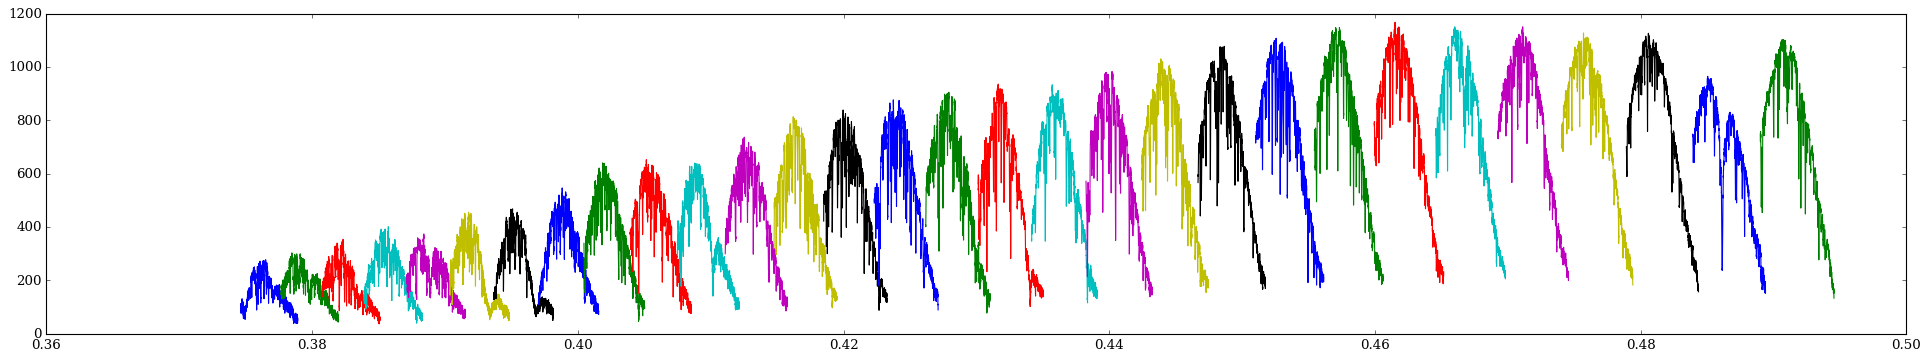

In [36]:
plt.figure(figsize=(30, 5))
# plt.plot(data["redl/wl_grid"][20], np.mean(data["redl/uncertainties"][20], axis=0))
for order_i in range(30):
    plt.plot(
        data["blue/wl_grid"][order_i],
        np.mean(data["blue/flux_blaze_corrected"][order_i], axis=0),
    )

(-0.001, 0.002)

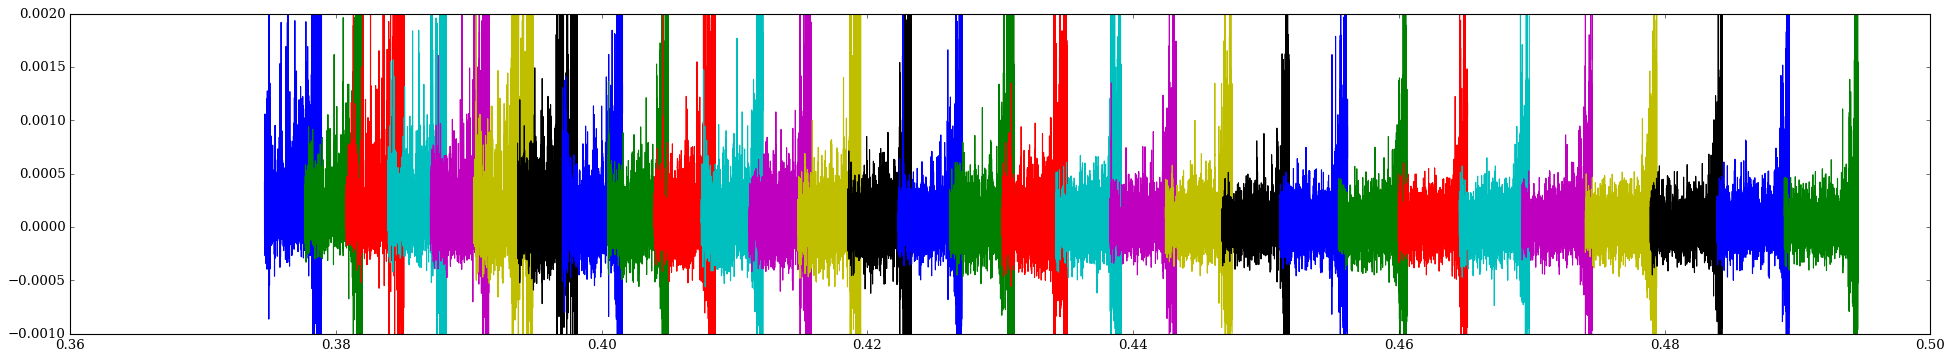

In [37]:
plt.figure(figsize=(30, 5))
# plt.plot(data["redl/wl_grid"][20], np.mean(data["redl/uncertainties"][20], axis=0))
for order_i in range(30):
    plt.plot(
        data["blue/wl_grid"][order_i], np.mean(data["blue/residuals"][order_i], axis=0)
    )
# plt.ylim(-50, 0)
# plt.xlim(0.382, 0.387)
plt.ylim(-0.001, 0.002)

In [18]:
a = data["redl/flux_blaze_corrected"][:]
print(len(a[a < 0]))
len(a.reshape(-1))

355000


11775920

In [19]:
a.shape

(26, 134, 3380)

In [12]:
262526 / 8210448

0.03197462550155607

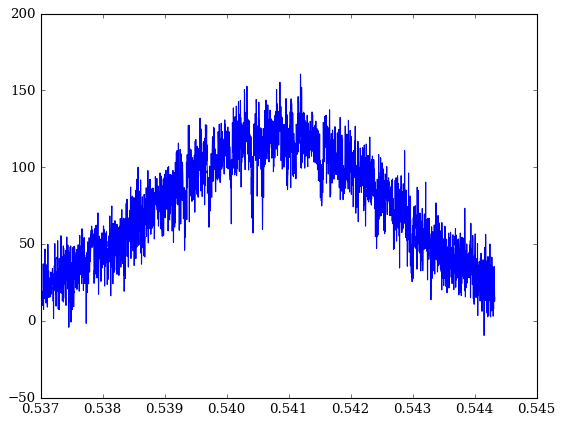

In [22]:
order_i = 4
plt.plot(data["redl/wl_grid"][order_i], np.mean(data["redl/flux"][order_i], axis=0))

In [38]:
chips = ["redl", "redu", "blue"]
# chips = ["blue"]

for chip in chips:
    flux = data[chip]["flux"][:]
    # flux[flux < 0] = 1e-7
    wl_grid = data[chip]["wl_grid"][:]
    N_order, N_phi, N_wl = flux.shape

    uncertainties = fit_uncertainties(flux)
    print("Finish fit uncertainties")

    if "flux_blaze_corrected" in data[chip]:
        blaze = np.zeros(flux.shape)
        for k in range(N_order):
            order = flux[k]
            median = np.median(order, axis=0)
            order_norm = order / median
            blaze[k] = order_norm

        for det in range(N_order):
            for phi in range(N_phi):
                blaze[det][phi] = median_filter(blaze[det][phi], size=15)

        for det in range(N_order):
            for phi in range(N_phi):
                blaze[det][phi] = gaussian_filter1d(blaze[det][phi], sigma=50)

        flux = flux / blaze
        print("Finish blaze correction")
        data[chip]["flux_blaze_corrected"][:] = flux
    else:
        blaze = np.zeros(flux.shape)
        for k in range(N_order):
            order = flux[k]
            median = np.median(order, axis=0)
            order_norm = order / median
            blaze[k] = order_norm

        for det in range(N_order):
            for phi in range(N_phi):
                blaze[det][phi] = median_filter(blaze[det][phi], size=15)

        for det in range(N_order):
            for phi in range(N_phi):
                blaze[det][phi] = gaussian_filter1d(blaze[det][phi], sigma=50)

        flux = flux / blaze

        print("Finish blaze correction")
        data[chip].create_dataset("flux_blaze_corrected", data=flux)

    # for k in range(N_order):
    #     flux[k] = flux[k] / np.median(flux[k], axis=0)
    residuals, Us = fast_filter(flux, uncertainties, N_iter=15)
    model = flux - residuals
    residuals = flux / model - 1

    uncertainties = uncertainties / model
    data[chip].require_dataset("residuals", shape=residuals.shape, dtype=float)
    data[chip]["residuals"][:] = residuals
    data[chip].require_dataset("uncertainties", shape=uncertainties.shape, dtype=float)
    data[chip]["uncertainties"][:] = uncertainties

-0.09955381983770131 469.8008180644995
-0.05339387210653044 470.14662325070935
-0.021803607999731918 472.8556148751104
0.023791983925274207 478.3643631353723
0.07571967184708536 480.17828001245806
0.13627183528864195 489.4297693906224
0.1969166732340006 493.1514125482987
0.26149887532287003 490.82502797785
0.26107777471671817 504.450829395083
0.28791843162081315 503.78850084846516
0.347387227804092 497.9602346567195
0.3549612959211239 496.27790355825346
0.3930848374114708 448.95220382653855
0.34582555485099803 455.9310513366389
0.3637077390078953 441.17642043063825
0.3917579846177205 424.4527139056487
0.39331154342949487 429.6663304247627
0.40013366290754016 422.5046893882461
0.4008224548608961 423.49278604671974
0.39893039473683267 427.8654582015921
0.39009498011195587 437.3167529897602
0.39564685869039184 429.6464310933194
0.39594002281309404 435.4789409039896
0.3777530521878653 460.1669739570092
0.37911691347792925 450.8228736159575
0.40720401051776695 436.73586049560845
Finish fit 

10/11 test sysrem subtract median first??? Preprocessed before sleep.

In [ ]:
# chips = ["redl", "redu", "blue"]
# # chips = ["blue"]

# for chip in chips:
#     flux = data[chip]["flux"][:]
#     flux[flux < 0] = 1e-7
#     wl_grid = data[chip]["wl_grid"][:]
#     N_order, N_phi, N_wl = flux.shape
#     if "flux_blaze_corrected" in data[chip]:
#         blaze = np.zeros(flux.shape)
#         for k in range(N_order):
#             order = flux[k]
#             median = np.median(order, axis=0)
#             order_norm = order / median
#             blaze[k] = order_norm

#         for det in range(N_order):
#             for phi in range(N_phi):
#                 blaze[det][phi] = median_filter(blaze[det][phi], size=15)

#         for det in range(N_order):
#             for phi in range(N_phi):
#                 blaze[det][phi] = gaussian_filter1d(blaze[det][phi], sigma=50)

#         flux = flux / blaze
#         print("Finish blaze correction")
#         data[chip]["flux_blaze_corrected"][:] = flux
#     else:
#         blaze = np.zeros(flux.shape)
#         for k in range(N_order):
#             order = flux[k]
#             median = np.median(order, axis=0)
#             order_norm = order / median
#             blaze[k] = order_norm

#         for det in range(N_order):
#             for phi in range(N_phi):
#                 blaze[det][phi] = median_filter(blaze[det][phi], size=15)

#         for det in range(N_order):
#             for phi in range(N_phi):
#                 blaze[det][phi] = gaussian_filter1d(blaze[det][phi], sigma=50)

#         flux = flux / blaze

#         print("Finish blaze correction")
#         data[chip].create_dataset("flux_blaze_corrected", data=flux)

#     uncertainties = fit_uncertainties(flux)
#     print("Finish fit uncertainties")

#     for i in range(N_order):
#         order = flux[i]
#         # out_of_transit_frames = np.concatenate((order[:20], order[-20:]), axis=0)
#         median = np.median(order, axis=0)
#         order_norm = order / median
#         uncertainty = uncertainties[i]

#         uncertainty_norm = uncertainty / median

#         uncertainties[i] = uncertainty_norm
#         flux[i] = order_norm

#     residuals, Us = fast_filter(flux, uncertainties, N_iter=15)

#     Bs = np.zeros((N_order, N_phi, N_phi))

#     for j in range(N_order):
#         U = Us[j]
#         L = np.diag(1 / np.mean(uncertainties[j], axis=-1))
#         B = U @ np.linalg.pinv(L @ U) @ L
#         Bs[j] = B

#     data[chip].require_dataset("residuals", shape=residuals.shape, dtype=float)
#     data[chip]["residuals"][:] = residuals
#     data[chip].require_dataset("Bs", shape=Bs.shape, dtype=float)
#     data[chip]["Bs"][:] = Bs
#     data[chip].require_dataset("uncertainties", shape=uncertainties.shape, dtype=float)
#     data[chip]["uncertainties"][:] = uncertainties

In [ ]:
for key in data.keys():
    print(data[key])
data.close()

In [ ]:
def read(data_all):
    for key in data_all.keys():
        data = data_all[key]
        wl_grid = data["wl_grid"][:]
        residuals = data["residuals"][:]
        Bs = data["Bs"][:]
        phi = data["phi"][:]
        transit_weight = data["transit_weight"][:]
        uncertainties = data["uncertainties"][
            :
        ]  # in case we want to null uncertainties

In [ ]:
data_dic = {}

for key in ["blue", "redl", "redu"]:
    data_dic[key] = {}

    def func(name, obj):
        data_dic[key][name] = obj[:]

    data[key].visititems(func)

In [ ]:
data_dic["blue"].keys()